In [1]:
#Python/Data
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
import numpy as np
import h5py as h5
import uproot3 as ur
import awkward as ak
from data_functions import *
from matplotlib import style


import os
import shutil

#ML
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split
import tensorflow as tf
GeV_to_MeV=1000

import mplhep as hep
hep.set_style(hep.style.CMS)
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

shuffle_split = True

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow import keras
from tensorflow.keras import layers

2023-02-24 13:03:24.832807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 13:03:25.872601: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bishnu/Library/root/lib:/usr/local/lib:/usr/local/lib:/usr/local/cuda-11.8/lib64
2023-02-24 13:03:25.872745: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bishnu/Library/root/lib:/usr/local/li

In [2]:
learning_rate = 1e-5
dropout_rate = 0.05
batch_size = 128
N_Epochs = 400
patience = 20
N_Latent = 128
shuffle_split = False #Turn FALSE for images!
train_shuffle = False #False for better root hf comparison
Y_scalar = True
loss = 'mae'
#loss = tf.keras.losses.MeanAbsoluteError()

## Read the information from the Tree

In [3]:
N_Events=200000
sampling_fraction=0.02
#root_file = "/media/miguel/Elements/Data_hcali/Data1/log_uniform_pi+_20deg.root"
root_file = "/media/miguel/Elements/Data_hcali/Data1/Jan_2023_log_space_Files/log_uniform_pi+_17deg_jan26_23.root"

#root_file = "/media/miguel/Elements/Data_hcali/Data1/Jan_2023_log_space_Files/PFN_train_file"

detector_name = "HcalEndcapPHitsReco" #or "HcalEndcapPInsertHitsReco"                                                                                                
ur_file = ur.open( root_file )
ur_tree = ur_file['events']

#cut_primary = array["MCParticles.generatorStatus"]==1                                                                                                               
genPx = ur_tree.array('MCParticles.momentum.x',entrystop=N_Events)[:,2]
genPy = ur_tree.array('MCParticles.momentum.y',entrystop=N_Events)[:,2]
genPz = ur_tree.array('MCParticles.momentum.z',entrystop=N_Events)[:,2]
mass = ur_tree.array("MCParticles.mass", entrystop=N_Events)[:,2]
root_gen_P = np.sqrt(genPx*genPx + genPy*genPy + genPz*genPz)
gen_energy=np.sqrt(root_gen_P**2 + mass**2)

hit_e =ur_tree.array(f'{detector_name}.energy' ,entrystop=N_Events)
PosRecoX = ur_tree.array(f'{detector_name}.position.x',entrystop=N_Events)
PosRecoY = ur_tree.array(f'{detector_name}.position.y',entrystop=N_Events)
PosRecoZ= ur_tree.array(f'{detector_name}.position.z',entrystop=N_Events)
time= ur_tree.array(f'{detector_name}.time',entrystop=N_Events)

#MIP= 0.0006
#time_threshold=2000
#hit_e_min=MIP*0.1 #0.06
#MIP_cuts = hit_e> hit_e_min 
#MIP_cuts=np.logical_and(MIP_cuts, time<time_threshold)
#hit_e=hit_e[MIP_cuts]
#gen_energy=gen_energy[MIP_cuts]
#cluster_sum_raw = ak.sum(hit_e,axis=-1)
#cluster_sum_temp = ak.to_numpy(cluster_sum_raw)
#cluster_sum=np.divide(cluster_sum_temp,sampling_fraction)

In [4]:
max_length = max(len(seq) for seq in hit_e)


In [5]:
log_hit=False
if log_hit:
    hit_e[hit_e==0]=0.000001
    hit_e=np.log10(hit_e)
    gen_energy=np.log10(gen_energy)
    
def get_mean_std():
    
    mean_hit=np.nanmean(ak.flatten(hit_e))
    std_hit=np.nanstd(ak.flatten(hit_e))
    '''
    mean_X=np.nanmean(ak.flatten(PosRecoX))
    std_X=np.nanstd(ak.flatten(PosRecoX))
    
    mean_Y=np.nanmean(ak.flatten(PosRecoY))
    std_Y=np.nanstd(ak.flatten(PosRecoY))
    
    mean_Z=np.nanmean(ak.flatten(PosRecoZ))
    std_Z=np.nanstd(ak.flatten(PosRecoZ))
    '''
    mean_target=np.nanmean(gen_energy)
    std_target=np.nanstd(gen_energy)
    
    print ('mean_hit=', mean_hit, '   std_hit = ', std_hit)
    '''
    print ('mean_X=' , mean_X, '   std_X =', std_X)
    
    print ('mean_Y=', mean_Y, '   std_Y = ', std_Y)
    print ('mean_Z=', mean_Z, '   std_Z = ', std_Z)
    '''
    
    
    print ('mean_target=', mean_target, '   std_target =', std_target)
    
#get_mean_std()

In [6]:
if log_hit==False:
    mean_hit= 0.0013525796176872475
    std_hit = 0.008820865515446804
    mean_target= 56.7935219292301  
    std_target=  80.59976326771323

else:
    mean_hit= -3.996334547054441
    std_hit =  0.8841258843383055
    mean_target= 1.2015416612519736
    std_target = 0.7683784305726994


mean_X= -110.71318062140894
std_X = 986.3043191820791
mean_Y= -40.869369728254796
std_Y = 1010.5846773983045
mean_Z= 4407.6375918933545
std_Z = 322.61474120326426


In [7]:
# Tensorflow CallBacks                                                                                        
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decay,verbose=0)                                   
early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience)                                          
history_logger=tf.keras.callbacks.CSVLogger(path+"/log.csv", separator=",", append=True)                      
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path, save_best_only=True)                     
callbacks=[lr_scheduler, early_stopping,history_logger,batch_history(),model_checkpoint] 

-2.868862726221393

In [8]:


normalize_hite=(hit_e-mean_hit)/std_hit
processed_hit = pad_sequences(normalize_hite, maxlen=max_length, padding='post', dtype='float64')


normalize_X=(PosRecoX-mean_X)/std_X
processed_X = pad_sequences(normalize_X, maxlen=max_length,padding='post', dtype='float64')



normalize_Y=(PosRecoY-mean_Y)/std_Y
processed_Y = pad_sequences(normalize_Y, maxlen=max_length, padding='post', dtype='float64')



normalize_Z=(PosRecoZ-mean_Z)/std_Z
processed_Z = pad_sequences(normalize_Z, maxlen=max_length, padding='post', dtype='float64')


processed_target=(gen_energy - mean_target)/std_target

In [9]:
#processed_target=processed_target.reshape(-1,1)
# Concatenate the input data along the feature axis
input_data = np.concatenate([processed_hit[:, :, np.newaxis], 
                              processed_X[:, :, np.newaxis], 
                              processed_Y[:, :, np.newaxis], 
                              processed_Z[:, :, np.newaxis]], 
                             axis=2)


In [10]:
(X_train, X_val, X_test,
 
Y_train, Y_val, Y_test) = data_split(input_data, processed_target, val=0.2, test=0.3,shuffle=shuffle_split)

In [11]:
'''
(X1_train, X1_val, X1_test,
 X2_train, X2_val, X2_test,
 X3_train, X3_val, X3_test,
 X4_train, X4_val, X4_test,
Y_train, Y_val, Y_test) = data_split(processed_hit, processed_X, processed_Y, processed_Z,\
                                     processed_target, val=0.2, test=0.3,shuffle=shuffle_split)
'''                                     

'\n(X1_train, X1_val, X1_test,\n X2_train, X2_val, X2_test,\n X3_train, X3_val, X3_test,\n X4_train, X4_val, X4_test,\nY_train, Y_val, Y_test) = data_split(processed_hit, processed_X, processed_Y, processed_Z,                                     processed_target, val=0.2, test=0.3,shuffle=shuffle_split)\n'

In [12]:
num_pixels=input_data.shape[-2]
print(num_pixels)

4184


In [13]:
num_pixels=input_data.shape[-2]
# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(num_pixels, 4)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

# Compile the model
model.compile(loss=loss, callbacks=callbacks, optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
# Train the model
#model.fit(np.stack((energy, x_pos, y_pos, z_pos), axis=2), , batch_size=32, epochs=10)

2023-02-24 13:05:06.688022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 13:05:06.688314: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 13:05:06.798309: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bishnu/Library/root/lib:/usr/local/lib:/usr/local/lib:/usr/local/cuda-11.8/lib64
2023-02-24 13:05:06.798339: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed proper

In [14]:
history=model.fit(x=X_train, y=Y_train, epochs=N_Epochs, batch_size=526,validation_data=(X_val, Y_val))


'''
history=model.fit(x=[X1_train, X2_train, X3_train, X4_train], y=Y_train, epochs=20, batch_size=526,\
validation_data=([X1_val, X2_val, X3_val, X4_val],Y_val))
'''

Epoch 1/400


2023-02-24 13:05:07.957757: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 6694400000 exceeds 10% of free system memory.


191/191 [==============================] - 5s 24ms/step - loss: 0.4557 - val_loss: 0.2461
Epoch 2/400
191/191 [==============================] - 3s 17ms/step - loss: 0.1912 - val_loss: 0.1579
Epoch 3/400
191/191 [==============================] - 3s 17ms/step - loss: 0.1366 - val_loss: 0.1268
Epoch 4/400
191/191 [==============================] - 3s 18ms/step - loss: 0.1127 - val_loss: 0.1111
Epoch 5/400
191/191 [==============================] - 3s 17ms/step - loss: 0.0985 - val_loss: 0.1016
Epoch 6/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0892 - val_loss: 0.0943
Epoch 7/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0824 - val_loss: 0.0899
Epoch 8/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0772 - val_loss: 0.0864
Epoch 9/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0728 - val_loss: 0.0837
Epoch 10/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0692 - val_loss

191/191 [==============================] - 3s 18ms/step - loss: 0.0238 - val_loss: 0.0631
Epoch 81/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0237 - val_loss: 0.0631
Epoch 82/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0236 - val_loss: 0.0632
Epoch 83/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0234 - val_loss: 0.0631
Epoch 84/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0232 - val_loss: 0.0631
Epoch 85/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0231 - val_loss: 0.0632
Epoch 86/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0231 - val_loss: 0.0631
Epoch 87/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0229 - val_loss: 0.0630
Epoch 88/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0227 - val_loss: 0.0630
Epoch 89/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0227 - 

191/191 [==============================] - 3s 18ms/step - loss: 0.0168 - val_loss: 0.0630
Epoch 160/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0168 - val_loss: 0.0629
Epoch 161/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0168 - val_loss: 0.0631
Epoch 162/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0167 - val_loss: 0.0631
Epoch 163/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0167 - val_loss: 0.0629
Epoch 164/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0166 - val_loss: 0.0629
Epoch 165/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0166 - val_loss: 0.0628
Epoch 166/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0164 - val_loss: 0.0628
Epoch 167/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0165 - val_loss: 0.0629
Epoch 168/400
191/191 [==============================] - 3s 18ms/step - loss: 

Epoch 238/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0141 - val_loss: 0.0631
Epoch 239/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0140 - val_loss: 0.0631
Epoch 240/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0139 - val_loss: 0.0631
Epoch 241/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0140 - val_loss: 0.0631
Epoch 242/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0139 - val_loss: 0.0633
Epoch 243/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0138 - val_loss: 0.0633
Epoch 244/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0138 - val_loss: 0.0632
Epoch 245/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0139 - val_loss: 0.0632
Epoch 246/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0138 - val_loss: 0.0631
Epoch 247/400
191/191 [==============================] - 3s 18ms

Epoch 317/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0123 - val_loss: 0.0633
Epoch 318/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0125 - val_loss: 0.0633
Epoch 319/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0124 - val_loss: 0.0633
Epoch 320/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0123 - val_loss: 0.0632
Epoch 321/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0123 - val_loss: 0.0633
Epoch 322/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0124 - val_loss: 0.0632
Epoch 323/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0124 - val_loss: 0.0632
Epoch 324/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0122 - val_loss: 0.0633
Epoch 325/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0123 - val_loss: 0.0632
Epoch 326/400
191/191 [==============================] - 3s 18ms

Epoch 396/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0113 - val_loss: 0.0631
Epoch 397/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0113 - val_loss: 0.0633
Epoch 398/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0112 - val_loss: 0.0634
Epoch 399/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0114 - val_loss: 0.0632
Epoch 400/400
191/191 [==============================] - 3s 18ms/step - loss: 0.0113 - val_loss: 0.0633


'\nhistory=model.fit(x=[X1_train, X2_train, X3_train, X4_train], y=Y_train, epochs=20, batch_size=526,validation_data=([X1_val, X2_val, X3_val, X4_val],Y_val))\n'

(0.0, 0.5)

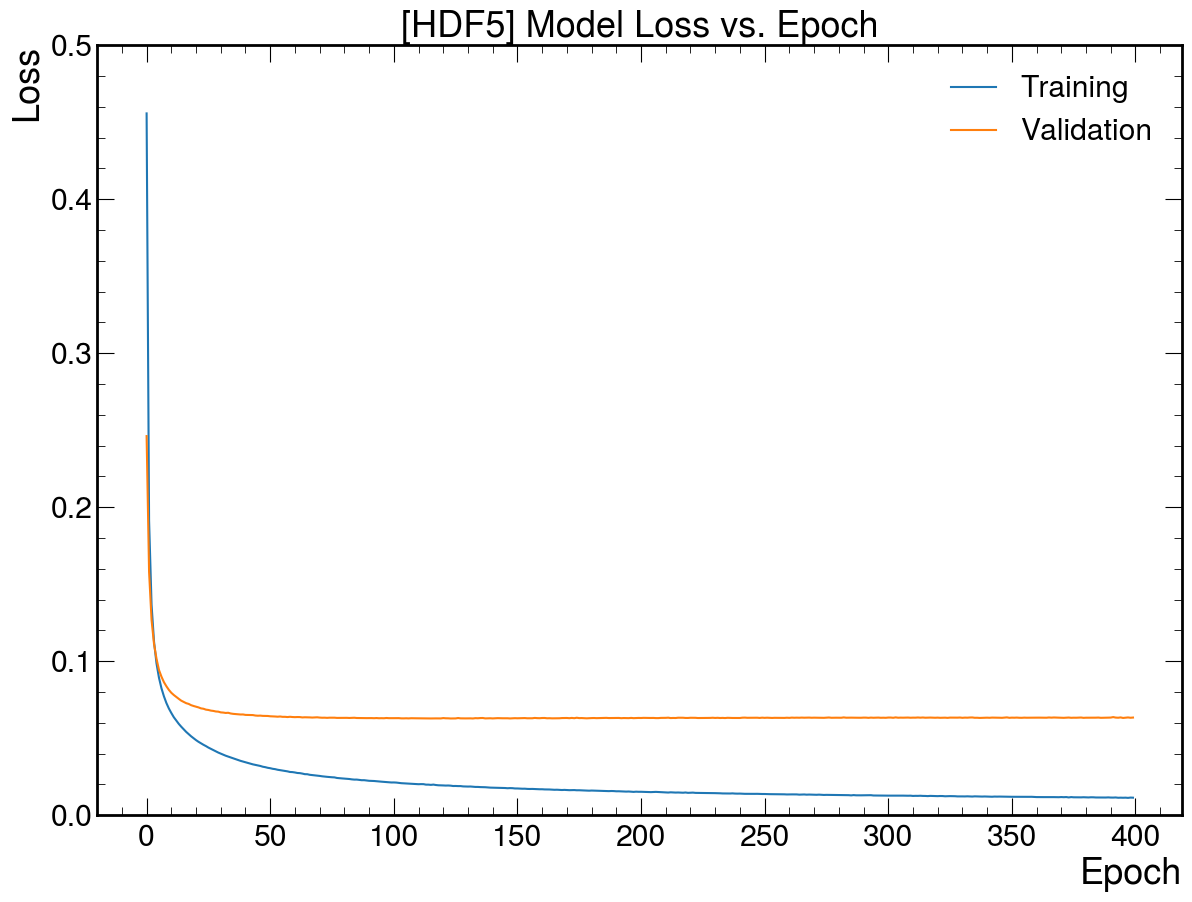

In [15]:
fig,axes=plt.subplots(figsize=(14,10))
axes.plot(history.history['loss'])
axes.plot(history.history['val_loss'])
axes.set_title('[HDF5] Model Loss vs. Epoch',fontsize=26)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
axes.set_ylim(0,0.5)

In [16]:
mypreds = model.predict(X_test)

1875/1875 [==============================] - 1s 722us/step


In [17]:
print(std_target, '   ' , mean_target)

80.59976326771323     56.7935219292301


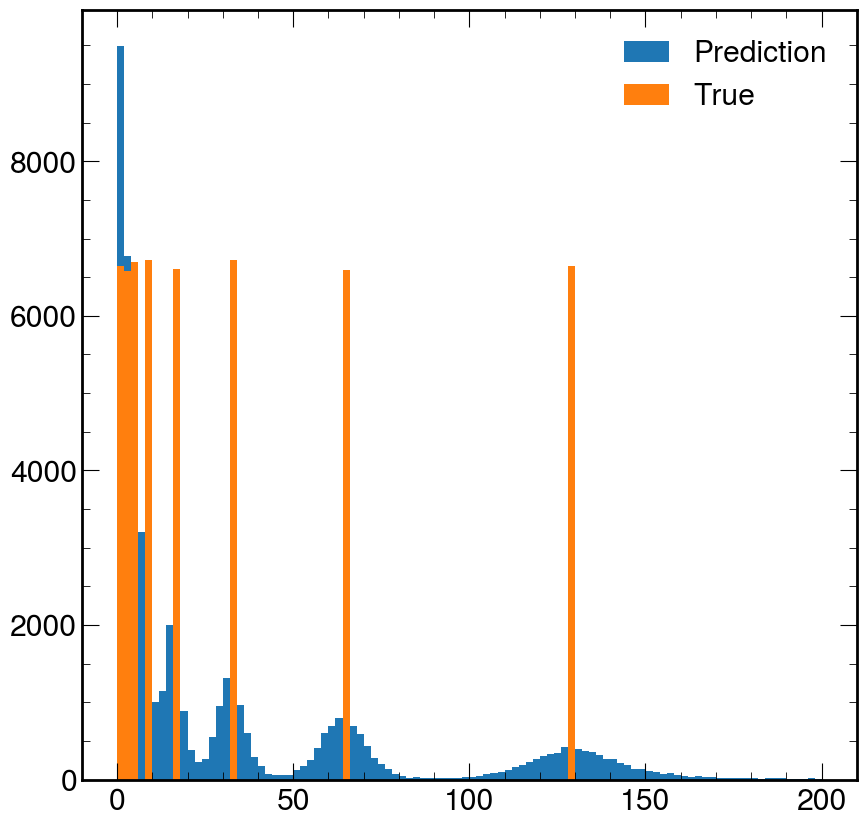

In [18]:
mypreds_final=mypreds*std_target + mean_target
Y_test_final=Y_test*std_target + mean_target
mypreds_final=mypreds_final[mypreds_final>0]
Y_test_final=Y_test_final[Y_test_final>0]

#mypreds_final[mypreds_final<0]=256
#Y_test_final[Y_test_final<0]=256

plt.hist(mypreds_final,bins=100, range=(0, 200))
plt.hist(Y_test_final, bins=100, range=(0,200))
plt.legend(['Prediction', 'True'])


In [19]:
# Get Resolution, scale, and distributions of Pred/X in bins of truth Using fit      
def get_res_scale_fit_log_local(truth, pred, file_name, num_bins, upto=256):
    nbins=num_bins
    
    ## Number of generated energy len(1, 2, 4, 8 ...)
    nn=int(np.log2(upto)) +1
    binning=[]
    
    ## Get the Generated Energy
    for n in range(0,nn):
        egen=pow(2,n)
        binning.append(egen)   
    print(nn, '   ', binning)    
    
    
    ## This should be same as binning[nn-1]
    max_ene_generated=int(np.amax(upto))
    print(max_ene_generated)
    
    ## This is same as nn
    N_Bins=int(np.log2(max_ene_generated))+1
    #print(max_ene_generated,'  ', N_Bins)
    
    #N_Bins=len(binning)  
    FIT_SIGMA=2 ## fit within +- 3 sigma    
    times=0.5    ## draw histogram within +- times sigma      
    bin_width=1 ## bin width of the histogram to be fitted   
    row=math.ceil(np.sqrt(N_Bins))
    col=row
    print("Hello")
    resolution_arr=[]
    mean_arr=[]
    resolution_cor_arr=[]
    scale_arr=[]
    avg_truth_arr=[]
    slices_arr=[]
    slices_truth_arr=[]
    scale_median_arr=[]
    fig,axs = plt.subplots(row,col, figsize=(22, 10),sharex=False)#,constrained_layout=True)
    
    if (len(truth) != len(pred)):
        print("truth and prediction arrays must be same length")
        #return

    #binning = np.linspace(min,max,N_Bins+1)
    truth=np.rint(truth)
    indecies = np.digitize(truth,binning)-1 #Get the bin number each element belongs to.
    #plt.hist(indecies)
    #indecies = indecies[indecies<=1]
    
    
    max_count = np.bincount(indecies).max()
       
    slices = np.empty((len(binning),max_count))
    slices_truth=np.empty((len(binning),max_count))
    slices_truth.fill(np.nan)
    slices.fill(np.nan)
    
    counter = np.zeros(len(binning),int) #for getting mean from sum, and incrementing element number in bin
    avg_truth = np.zeros(len(binning),float)
    pred_over_truth = np.zeros(len(binning),float)
    #xticks=np.linspace(0,E_xmax,6)
    one_ytics=round(max_count,-3)## round to thousand  
    yticks=np.linspace(0,one_ytics,6)
    
    for i in range(len(pred)):
        bin = indecies[i]
        if (bin>=len(binning)): continue
        slices[bin][counter[bin]] = pred[i] #slice_array[bin number][element number inside bin] = pred[i]   
        slices_truth[bin][counter[bin]] = truth[i]
        counter[bin]+=1

        avg_truth[bin]+=truth[i]
        pred_over_truth[bin] += pred[i]/truth[i]

    
    counter[counter == 0] = 1
    avg_truth = avg_truth/counter
    
    stdev_pred = np.nanstd(slices,axis=1)
    avg_pred   = np.nanmean(slices,axis=1)
    stdev_truth = np.nanstd(slices_truth,axis=1)
    median_pred=np.nanmedian(slices,axis=1)
    
    for ii in range(0,len(binning)):
        #print('Hello hello.   ' , ii)
        ## guess parameters for fitting    
        mean_guess=avg_pred[ii]
        sigma_guess=stdev_pred[ii]
        print(avg_pred[ii], '     ', stdev_pred[ii])

        ## min and max range for histogram to be fitted to extract resolution/scale  
        min_range=binning[ii] - times*binning[ii]
        max_range=binning[ii] + times*binning[ii]
        
        #print(min_range, ' max and min range. ', max_range)
        
        ## mean value of range within which histogram is draw    
        mean_here=(min_range + max_range)/2.0
        #print(mean_here)
        irow=int(ii/row)
        icol=int(ii%row)
        
        #print(irow,"  ", icol)    
        ax = axs[irow,icol]
        #print(nbins,'  ',min_range , '    ', max_range)
        
        count, bins,_=ax.hist(slices[ii].ravel(),bins=nbins,alpha=0.5,range=(min_range,max_range),label='HCALI',\
                              color='b',linewidth=8)
        
        #print( " energy   ", binning[ii], "      nbins    ", nbins)
        
        binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

        mask=(binscenters>(mean_guess-FIT_SIGMA*sigma_guess)) & (binscenters<(mean_guess+FIT_SIGMA*sigma_guess))
        error_counts=np.sqrt(count)
        error_counts=np.where(error_counts==0,1,error_counts)
        '''
        # PARAMETER BOUNDS ARE NOT USED FOR NOW       
        param_bounds=([-np.inf,-np.inf,-np.inf], [np.inf,np.inf,np.inf])
        
        
        popt, pcov = curve_fit(gaussian,binscenters[mask],count[mask],p0=[np.max(count),mean_guess,sigma_guess],bounds=param_bounds)

        ax.plot(binscenters[mask], gaussian(binscenters[mask], *popt), color='red', linewidth=2.5, label=r'F')
        
        mean=popt[1]
        std=popt[2]
        
        
        #ax.set_xticks(xticks,fontsize=15)
        ax.set_xlim(math.floor(min_range),math.ceil(max_range))
        for_plot=round(binning[ii])
        y_text_val=int(np.max(count))*0.7
        ax.text(binning[ii],y_text_val,"$E_{True}$" + "= {0:.0f} GeV".format(for_plot),fontsize=15)
        if irow==row-1:
           ax.set_xlabel('Predicted Energy (GeV)',fontsize=15)

        if icol==0:
           ax.set_ylabel("Entries",fontsize=15)


        plt.savefig(file_name)
        
        
        
        #mean=np.nanmean(slices[ii])
        #std=np.nanstd(slices[ii])
        #print(mean, 'Mean and std ', std)
        
        resolution=std/avg_truth[ii]
        scale_median=median_pred[ii]/avg_truth[ii]
        scale=mean/avg_truth[ii]
        resolution_scale_corr=(std/avg_truth[ii])/scale
        resolution_scale_corrected=np.nan_to_num(resolution_scale_corr)

        resolution_arr.append(resolution)
        mean_arr.append(mean)
        resolution_cor_arr.append(resolution_scale_corrected)
        scale_arr.append(scale)
        slices_arr.append(slices[ii])
        avg_truth_arr.append(avg_truth[ii])
        scale_median_arr.append(scale_median)
        slices_truth_arr.append(slices_truth[ii])
        '''
    #return resolution_arr,scale_arr,avg_truth_arr,slices_arr,resolution_cor_arr, scale_median_arr, slices_truth_arr
    

9     [1, 2, 4, 8, 16, 32, 64, 128, 256]
256
Hello
truth and prediction arrays must be same length
57.838213380220985       80.8856289838391
57.3333439334587       80.0799752774679
56.96195066731847       80.84259851054141
57.42201314661782       80.73876340198004
57.4221324706508       81.62562709175128
56.8772066181437       79.34378982562563
55.33374820771765       79.57735817624759
56.43914631188374       79.95696003133737
55.80156484075792       80.60279810510502


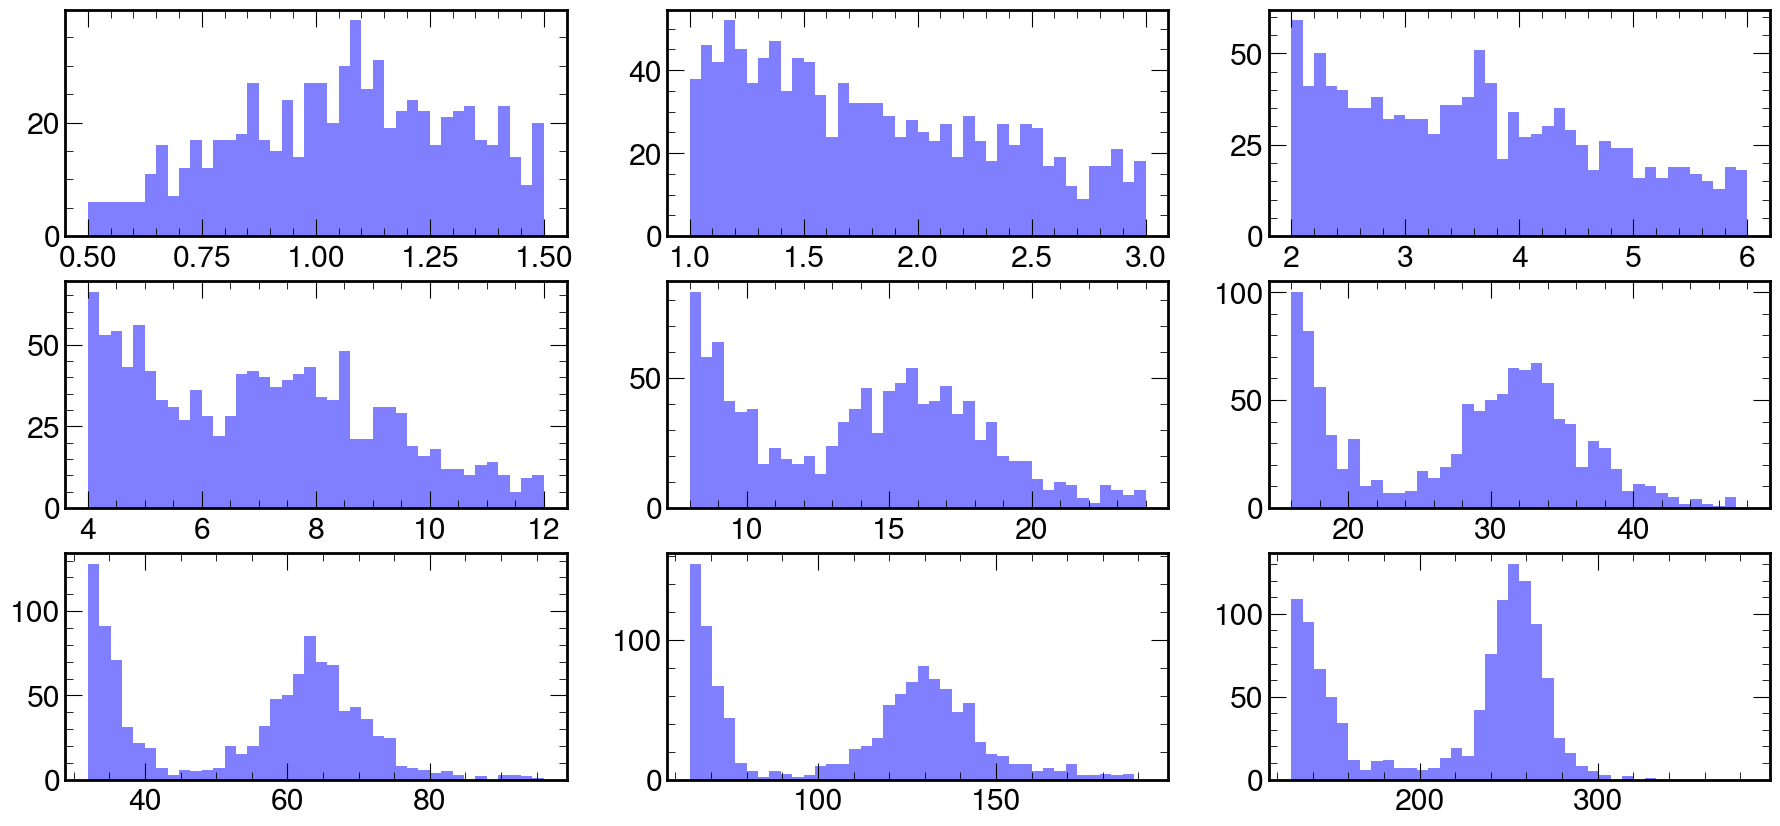

In [20]:
#from data_functions import *
working_dir="/home/bishnu/EIC"
new_dir="output_reg_dnn_straw_comp"
output_path=f"{working_dir}/{new_dir}"

save_slices=True
log_data=True
nbins=40
ene_upto=256

#print(len(mypreds_final))
#resolution_fit, pred_over_truth_fit, true_fit,slices_fit,resolution_scale_corr_fit, median_scale_fit,slices_truth = \
get_res_scale_fit_log_local(Y_test_final, mypreds_final, f"{output_path}/try.png",nbins,ene_upto)



#print(resolution_arth,"    ", pred_over_truth_arth)

## Below this is not need 

In [21]:
def plot_histogram():   
    plt.hist(ak.flatten(processed_hit*std_hit + mean_hit), bins=100, range=(0,2))
    plt.yscale('log')
    plt.hist(ak.flatten(hit_e), bins=100, range=(0,2))
    plt.yscale('log')
#plot_histogram()    

In [22]:
print(processed_hit.shape)
print(processed_Z.shape)
print(processed_target.shape)
processed_target.reshape

(200000, 4184)
(200000, 4184)
(200000,)


<function ndarray.reshape>

NameError: name 'X1_train' is not defined

In [ ]:
#from data_functions import *
working_dir="/home/bishnu/EIC"
new_dir="output_reg_dnn_straw_comp"
output_path=f"{working_dir}/{new_dir}"

save_slices=True
log_data=True
nbins=40
ene_upto=256

print(len(mypreds_final))
#resolution_fit, pred_over_truth_fit, true_fit,slices_fit,resolution_scale_corr_fit, median_scale_fit,slices_truth = \
get_res_scale_fit_log_local(Y_test_final, mypreds_final, f"{output_path}/try.png",nbins,ene_upto)



#print(resolution_arth,"    ", pred_over_truth_arth)


## Get mean and standard Deviation before zero padding

In [ ]:
input_data_before_processing=[hit_e, PosRecoX, PosRecoY,PosRecoZ, gen_energy]
mean_list=[]
std_list=[]
for arr in input_data_before_processing:
    mean_arr=np.nanmean(np.ravel(arr))

In [ ]:


def get_mean_std_input(input_data_before_processing):
    N_events_for_mean=2000
    input_keys = ["E","X","Y","Z", "target"] # match HDF5 File format    
    input_means=np.zeros(len(input_keys))
    input_stdevs=np.zeros(len(input_keys))
    for ii in range(len(input_keys)):
        input_means[ii]  = np.nanmean(ak.ravel(input_data_before_processing[ii][0:N_events_for_mean]))
        input_stdevs[ii] = np.nanstd (ak.ravel(input_data_before_processing[ii][0:N_events_for_mean]))

    return input_means, input_stdevs  


input_mean, input_std=get_mean_std_input(input_data_before_processing)
#target_mean, target_std= get_mean_std_target(gen_energy)  


print(input_mean)
print(input_std)
#print(target_mean,'   ',target_std)

In [ ]:
print(PosRecoX[0,0:10])
print(hit_e[0,0:10])

## Normalization of input data before zero padding

In [ ]:
def do_normalization(input_data, input_mean, input_std):
    #print(input_mean, "   ",  input_std)
    input_keys = ["E","X","Y","Z"]
   
    for ii in range(len(input_data)):
        input_data[ii]=(ak.ravel(input_data[ii]) - input_mean[ii])/input_std[ii] 
     
    return input_data
    
#input_data=np.[hit_e, PosRecoX, PosRecoY, PosRecoZ]
norm_input_data=do_normalization(input_data_before_processing, input_mean, input_std)
#norm_input_data1=np.array(norm_input_data)



In [ ]:
#plt.hist(np.ravel(norm_input_data[4]), bins=100, range= (-1, 1))


In [ ]:
plt.hist(np.ravel(processed_hit_e[:,:,0][processed_hit_e[:,:,0]!=0]))

In [ ]:
print(input_data.shape)
print(type(input_data))
index=3
plt.hist(np.ravel(input_data[:,:,index][input_data[:,:,index]!=0]), bins=100,range=(0,6000))
plt.yscale('log')

In [ ]:
print(type(norm_input_data))
print(norm_input_data.shape)
index=3
plt.hist(ak.ravel(norm_input_data[:,:,index][norm_input_data[:,:,index]!=0]), bins=10,range=(-10,10))

In [ ]:
n_hits = []
def get_nhits():
    for arr in hit_e:
        n_hits.append(len(arr))
get_nhits()        
#print(n_hits)


In [ ]:
input_shape=processed_hit_e.shape
# Define the model architecture
R_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=R_X_train.shape[1:]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(output_dim)
])




R_model = tf.keras.models.Sequential([
        #tf.keras.layers.Input(shape=[1]),
        tf.keras.layers.Dense(64, activation='relu'), # 1st hiddden layer
        tf.keras.layers.Dense(64, activation='relu'), # 2nd hiddden layer
        tf.keras.layers.Dense(64, activation='relu'), # 3rd hiddden layer
        tf.keras.layers.Dense(64, activation='relu'), # 4th hiddden layer
        tf.keras.layers.Dense(1,activation="linear") # output layer
    ])

R_model.compile(loss=loss, optimizer="adam")


R_fit = R_model.fit(R_X_train, R_Y_train, epochs=5,
                        validation_data=(R_X_val,R_Y_val),
                        #callbacks=[lr_decay,early_stopping],
                        batch_size=batch_size
                   )
                 
                    

In [ ]:
mypreds = R_model.predict(R_X_test)#,batch_size=400)    

In [ ]:
fig,axes=plt.subplots(figsize=(14,10))

axes.plot(R_fit.history['loss'])
axes.plot(R_fit.history['val_loss'])
axes.set_title('[HDF5] Model Loss vs. Epoch',fontsize=26)

In [ ]:
plt.hist(mypreds)

## Reading the stored information from DNN training

In [ ]:
working_dir="/home/bishnu/EIC"
new_dir="DNN_output"
output_path=f"{working_dir}/{new_dir}"

mypreds_read=np.load(f"{output_path}/predictions.npy")
test_read=np.load(f"{output_path}/test_data.npy")
#mypreds_back=pow(10,mypreds_read)
#test_back=pow(10,test_read)

In [ ]:
plt.hist(mypreds_read, bins=100, range=(0,200), label='predictions')
plt.hist(test_read, bins=100, range=(0,200), label='true')

In [ ]:
df=pd.read_csv(f"{output_path}/log.csv")

In [ ]:
ax=df.plot(x='epoch', y='loss', color="red",marker='*', linestyle='dashed',linewidth='2',grid=True, label="train", figsize=(5,5))
ax=df.plot(x='epoch', y='val_loss', color="blue",marker='*', linestyle='dashed',ax=ax,linewidth='2',grid=True, label="validation", figsize=(5,5))
#plt.plot
ax.set_xlim(0,50)
ax.set_ylim(0,.5)
ax.set_ylabel('loss', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
plt.show()

In [ ]:
#from data_functions import *
working_dir="/home/bishnu/EIC"
new_dir="output_reg_dnn_straw_comp"
output_path=f"{working_dir}/{new_dir}"

save_slices=True
log_data=True
nbins=40
ene_upto=256

#print(len(mypreds_final))
#resolution_fit, pred_over_truth_fit, true_fit,slices_fit,resolution_scale_corr_fit, median_scale_fit,slices_truth = \
get_res_scale_fit_log_local(test_read, mypreds_read, f"{output_path}/try.png",nbins,ene_upto)



#print(resolution_arth,"    ", pred_over_truth_arth)

## Different articheture used in DNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense